In [1]:
from implicit_als.read_dump import read_dump
import pandas as pd
import matplotlib.pyplot as plt

# Convert data

sql dump -> csv. Next load the data to the table

In [2]:
path = '/data/groupLe_recsys/books/raw/book-recommender-users.sql'
csv_path = '/data/groupLe_recsys/books/views.csv'
table = 'book_recomm'

In [3]:
with open(csv_path, 'w') as f:
    f.write(read_dump(path, table).getvalue())

In [4]:
df = pd.read_csv(csv_path, header=None)
df.columns = 'item_id rate user_id status date_created'.split()
df = df.drop('date_created', axis=1)
df.head()

,item_id,rate,user_id,status
0,234705,0,4,2
1,234705,0,116482,5
2,234705,10,151556,2
3,234705,10,102324,2
4,234705,0,72880,5


In [5]:
df.shape

(1061124, 4)

# delete NA

In [6]:
print('na percent', round(df[df.rate.isna()].shape[0]/df.shape[0]*100, 2))

na percent 0.0


In [7]:
df = df[~df.rate.isna()]

In [8]:
df.isna().sum()

item_id    0
rate       0
user_id    0
status     0
dtype: int64

# View data

In [9]:
hist_params = {'bins': 400, 'figsize': (25, 2)}

<AxesSubplot:>

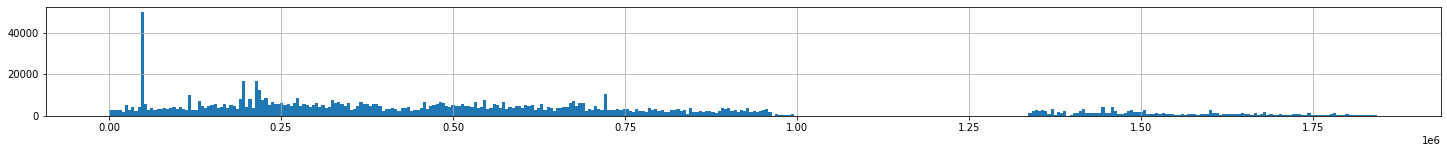

In [10]:
# id пользователей
df.user_id.hist(**hist_params)

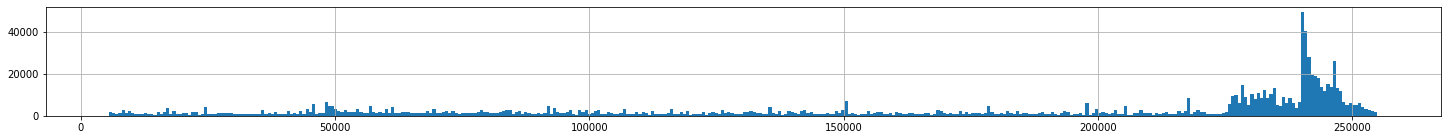

In [11]:
# id объектов
df.item_id.hist(**hist_params)
plt.savefig('./plot.png')

In [12]:
print(df.item_id.drop_duplicates().shape[0], 'уникальных объектов')
print(df.user_id.drop_duplicates().shape[0], 'уникальных пользователей')

78463 уникальных объектов
77262 уникальных пользователей


<AxesSubplot:>

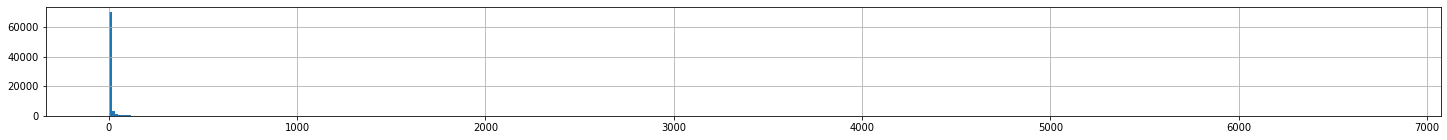

In [13]:
# Количество оценок для каждого объекта
df.groupby('item_id').count()['rate'].hist(**hist_params)

<AxesSubplot:>

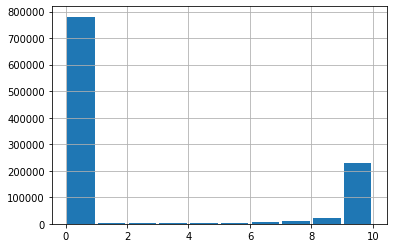

In [14]:
# Как оценивают
df.rate.hist(bins=10, rwidth=0.9)

<AxesSubplot:>

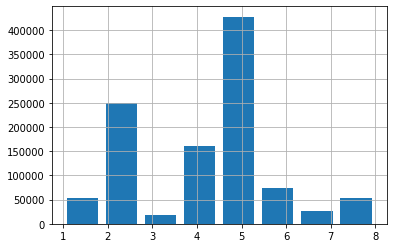

In [15]:
# Статусы
df.status.hist(bins=df.status.drop_duplicates().shape[0],rwidth=0.8)

In [16]:
df.rate.drop_duplicates()

0        0
2       10
31       8
33       1
61       9
447      7
946      6
1114     4
1387     5
2451     3
2944     2
Name: rate, dtype: int64

# Clean data

In [17]:
from implicit_als.preprocessor import Preprocessor

In [18]:
preprocessor = Preprocessor()

df = preprocessor.filter_zeros(df)
df = preprocessor.filter_lazy_users(df, 0)

In [19]:
df.shape

(280371, 4)

In [20]:
df.to_csv(csv_path)

# Split data

In [21]:
from tqdm.notebook import tqdm
from random import shuffle
import numpy as np

In [22]:
user_freqs = list(zip(df.user_id.drop_duplicates().sort_values().tolist(), df.groupby('user_id').count()['rate'].sort_index().to_list()))
user_freqs = {item[0] : item[1] for item in user_freqs}

min_freq = 3
max_freq = 10000

avg_users = [key if 
                 val > min_freq and \
                 val < max_freq 
                 else None 
             for key, val in user_freqs.items()]

avg_users = list(filter(lambda x: x != None, avg_users))
print(round(len(avg_users) / df.user_id.drop_duplicates().shape[0] * 100, 1), '%')

26.2 %


In [23]:
print(df.shape[0])
df = df[df.user_id.isin(avg_users)]
print(df.shape[0])

280371
214316


<AxesSubplot:>

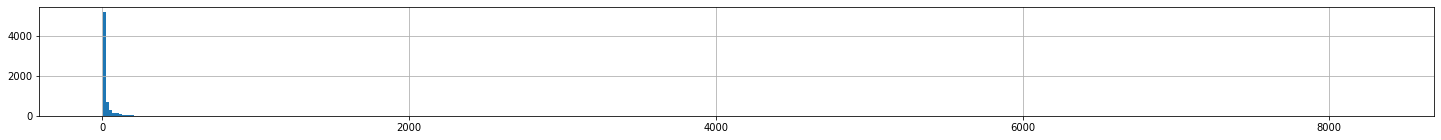

In [24]:
df.groupby('user_id').count()['rate'].hist(**hist_params)

In [25]:
users_sessions = df.groupby('user_id')['item_id rate'.split()].apply(lambda l: list(zip(
                                                                                    l['item_id'].tolist(), 
                                                                                    l['rate'].tolist()
                                                                                    )
                                                                                ))

In [26]:
test_k = min_freq // 2

test_df = []
train_df= []

for user, history in tqdm(list(zip( users_sessions.index.tolist(), users_sessions.tolist() ))):
    views = [(user, item, rate) for item, rate in history]
    np.random.shuffle(views)
    test_views = views[:test_k]
    train_views= views[test_k:]
    
    test_df += test_views
    train_df += train_views
    
train_df = pd.DataFrame.from_records(train_df, columns='user_id item_id rate'.split())
test_df = pd.DataFrame.from_records(test_df, columns='user_id item_id rate'.split())

In [27]:
train_df.shape, test_df.shape

((207507, 3), (6809, 3))

In [28]:
train_df.to_csv(csv_path.replace('views.csv', 'train/views.csv'), index=False)
test_df.to_csv(csv_path.replace('views.csv', 'test/views.csv'), index=False)